# Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the trained Mask R-CNN model.

## Installing and getting the crucial software libraries

In [23]:
!pip install imgaug
!pip install Cython
!pip install pycocotools


import time
import cv2
import datetime
import skimage.draw
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


##Download the workshop git repo to access the mask-rcnn software library and the dataset

In [24]:
os.chdir('/content')
!rm -rf Mask_RCNN
!git clone https://github.com/aneeshchauhan/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 2706 (delta 0), reused 1 (delta 0), pack-reused 2702
Receiving objects: 100% (2706/2706), 119.58 MiB | 31.19 MiB/s, done.
Resolving deltas: 100% (610/610), done.


**Change to the workshop working directory**

In [25]:
os.chdir('/content/Mask_RCNN/samples')

!pwd

/content/Mask_RCNN/samples


**Setup to start using the library**

In [26]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
DATASET_DIR = '../datasets/Ara2013-Canon'

print(ROOT_DIR)
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

from samples.leaf import leaf

/content/Mask_RCNN


In [0]:
#Root directory of the project


# # Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
# from mrcnn.config import Config


# # Path to trained weights file
# COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# # Directory to save logs and model checkpoints, if not provided
# # through the command line argument --logs

# #Options are coco or imagenet
# # WHICH_WEIGHTS = 'imagenet'
# WHICH_WEIGHTS = 'coco'
# DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs/coco_heads")

# # Directory to save logs and trained model
# MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# # Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# # Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)

##Download the trained model

In [28]:
# from google.colab import files
# files.upload()
# import data

!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd


LEAF_MODEL_PATH = os.path.join(ROOT_DIR, "leaf_model.h5")

gdd.download_file_from_google_drive(file_id='1kjxxa71hV9LvBHgS42jY5gWXsGdZFFgq',
                                    dest_path=LEAF_MODEL_PATH)
                                    

In [29]:
#Sanity check (leaf_model.h5 should be 171M)
!ls -hal ../

total 171M
drwxr-xr-x 8 root root 4.0K Jul  9 18:11 .
drwxr-xr-x 1 root root 4.0K Jul  9 18:11 ..
drwxr-xr-x 2 root root 4.0K Jul  9 18:11 assets
drwxr-xr-x 3 root root 4.0K Jul  9 18:11 datasets
drwxr-xr-x 8 root root 4.0K Jul  9 18:11 .git
-rw-r--r-- 1 root root  569 Jul  9 18:11 .gitignore
drwxr-xr-x 2 root root 4.0K Jul  9 18:11 images
-rw-r--r-- 1 root root 171M Jul  9 18:11 leaf_model.h5
-rw-r--r-- 1 root root 1.1K Jul  9 18:11 LICENSE
-rw-r--r-- 1 root root   58 Jul  9 18:11 MANIFEST.in
drwxr-xr-x 2 root root 4.0K Jul  9 18:11 mrcnn
-rw-r--r-- 1 root root  14K Jul  9 18:11 README.md
-rw-r--r-- 1 root root  119 Jul  9 18:11 requirements.txt
drwxr-xr-x 7 root root 4.0K Jul  9 18:11 samples
-rw-r--r-- 1 root root   99 Jul  9 18:11 setup.cfg
-rw-r--r-- 1 root root 2.5K Jul  9 18:11 setup.py


## Configuration
Set some basic info aout the trained model which is necessary for Inference

In [0]:
# EPOCHS = 100

class LeafConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "leaf"
    
    # Supported values are: resnet50, resnet101.
    BACKBONE = "resnet50"
    
    
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 100
    
#     LEARNING_RATE = 0.005
    LEARNING_RATE = 0.0021
    LEARNING_MOMENTUM = 0.9

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    

    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128


    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + leaf

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 200

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [31]:
# Override the training configurations with a few
# changes for inferencing.

config = LeafConfig()
DATASET_DIR = "../datasets/Ara2013-Canon"

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0021
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [0]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

##Load Validation Dataset

In [34]:
# Build validation dataset
dataset = leaf.LeafDataset()
dataset.load_leaf(DATASET_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Image_DIR:  ../datasets/Ara2013-Canon/val/images
Class ids [1]
Images: 12
Classes: ['BG', 'leaf']


**Setup the model for inference (i.e. object detection and classification)**

In [35]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=ROOT_DIR,
                              config=config)

weights_path = LEAF_MODEL_PATH


# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/Mask_RCNN/leaf_model.h5


##Run Detection

image ID: leaf.10 (9) leaf.404
Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  185.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   68.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
gt_class_id              shape: (6,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (6, 4)                min:   13.00000  max:  113.00000  int32
gt_mask                  shape: (56, 56, 6)           min:    0.00000  max:    1.00000  bool


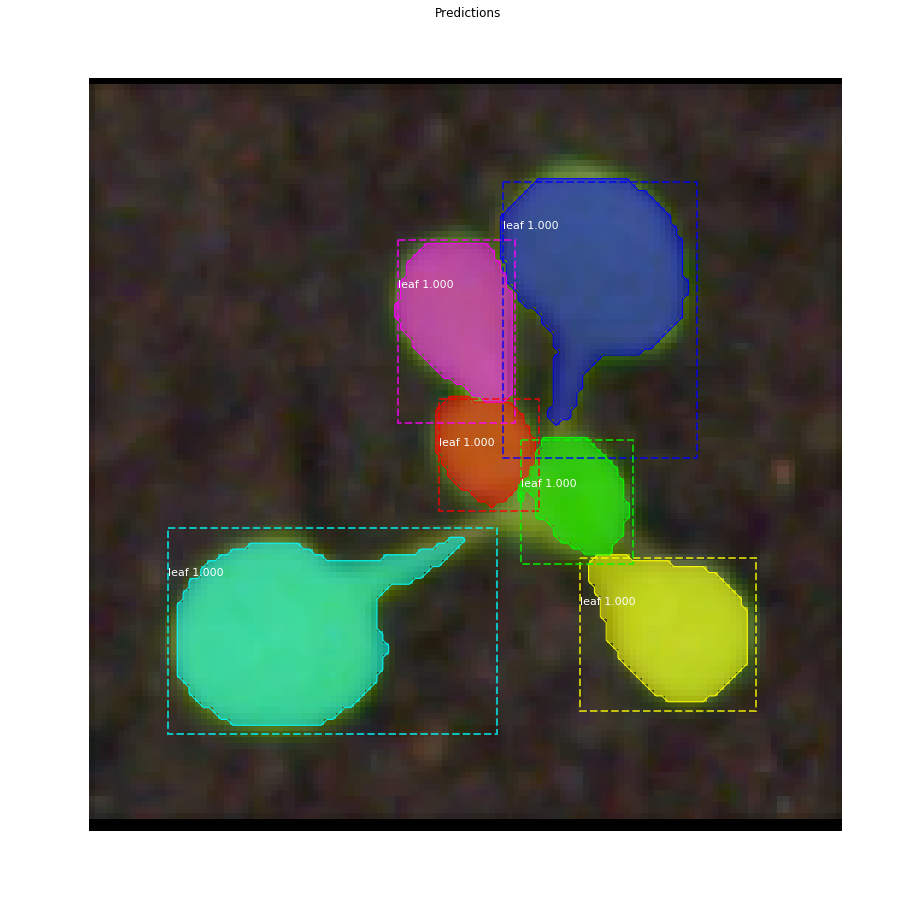

In [36]:
image_id = random.choice(dataset.image_ids)
# image_id = dataset.image_ids[0]
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=True)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

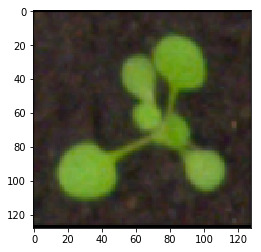

9


In [37]:
#Original image
plt.imshow(image)
plt.show()
print(image_id)

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [39]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

target_rpn_match         shape: (4092,)               min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -2.50000  max:    3.32514  float64
positive_anchors         shape: (7, 4)                min:  -13.25483  max:  118.62742  float64
negative_anchors         shape: (249, 4)              min:  -64.00000  max:  134.62742  float64
neutral anchors          shape: (3836, 4)             min:  -90.50967  max:  154.50967  float64
refined_anchors          shape: (7, 4)                min:   13.00000  max:  113.00000  float32


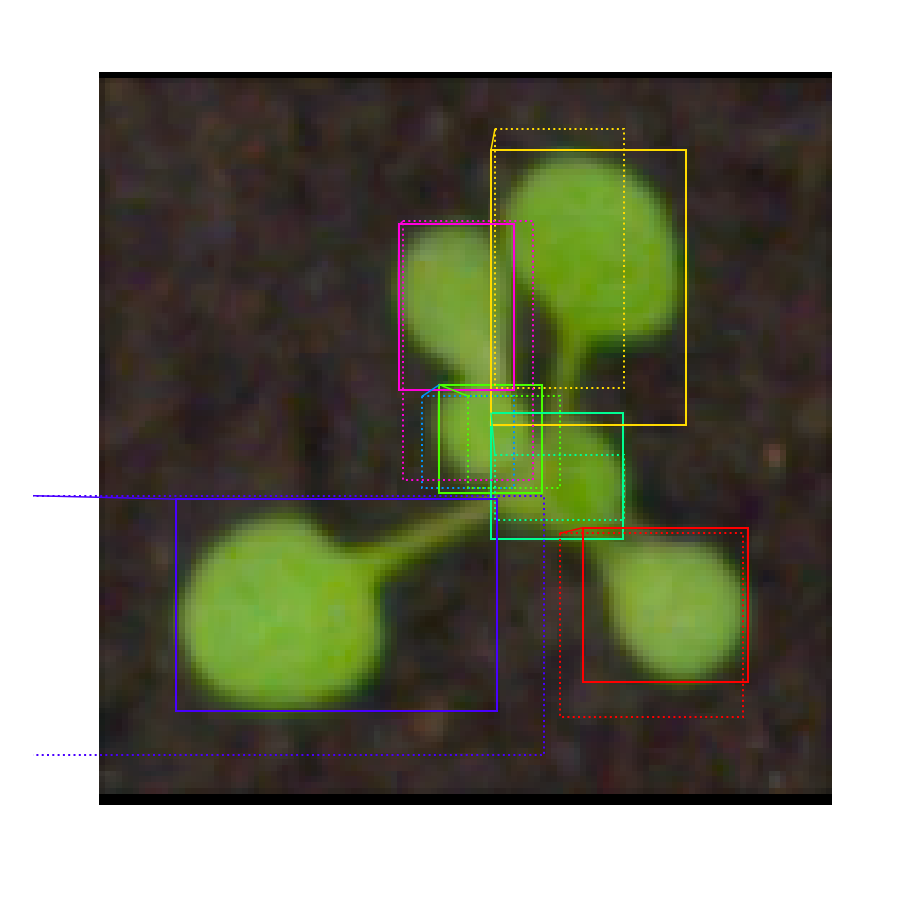

In [40]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [41]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 4092, 2)          min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
refined_anchors          shape: (1, 4092, 4)          min: -42233.33203  max: 42234.68359  float32
refined_anchors_clipped  shape: (1, 4092, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (307,)                min:    0.00000  max: 2648.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


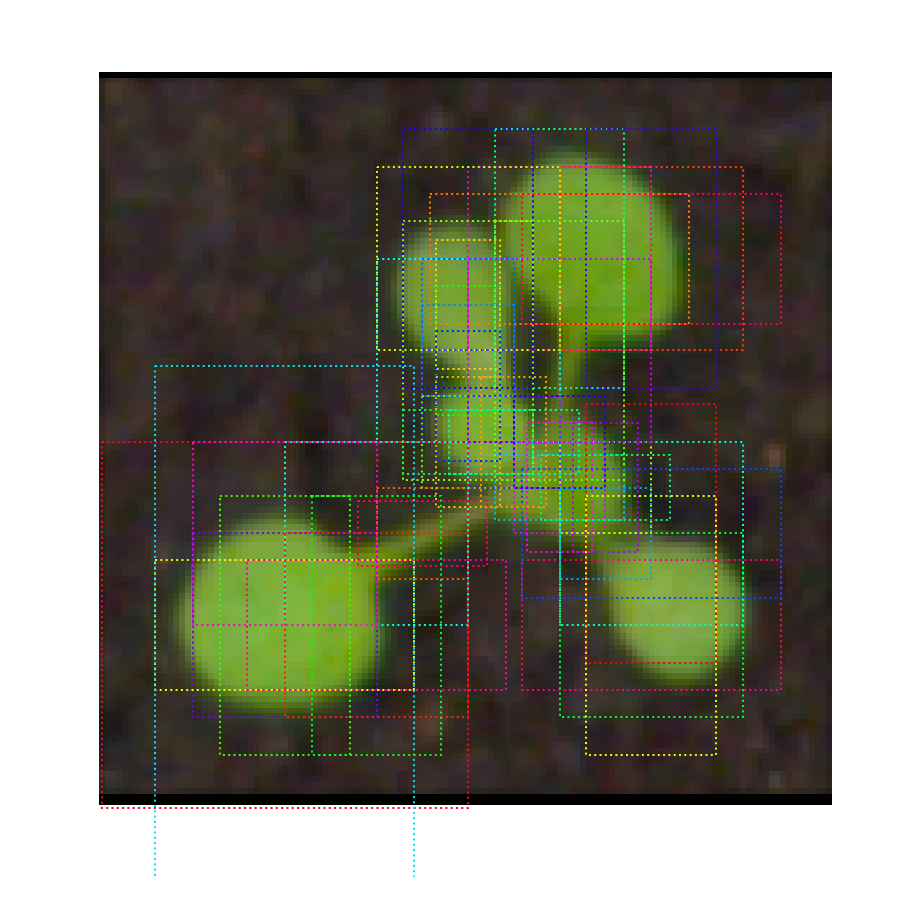

In [42]:
# Show top anchors by score (before refinement)
limit = 50
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

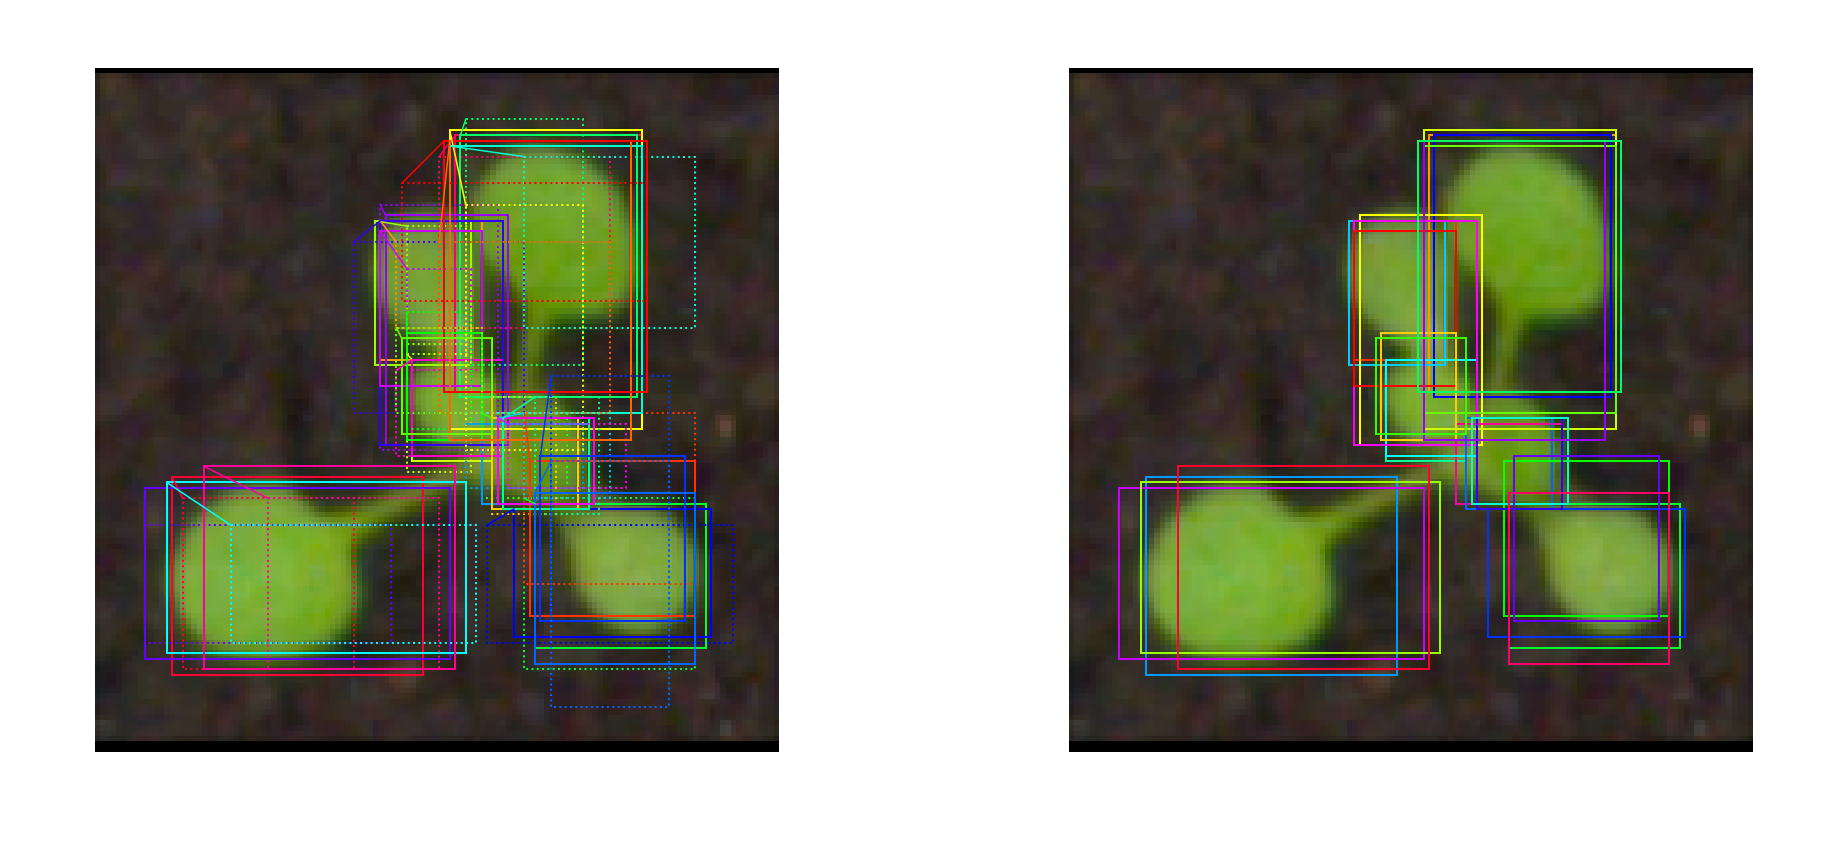

In [43]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 30
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

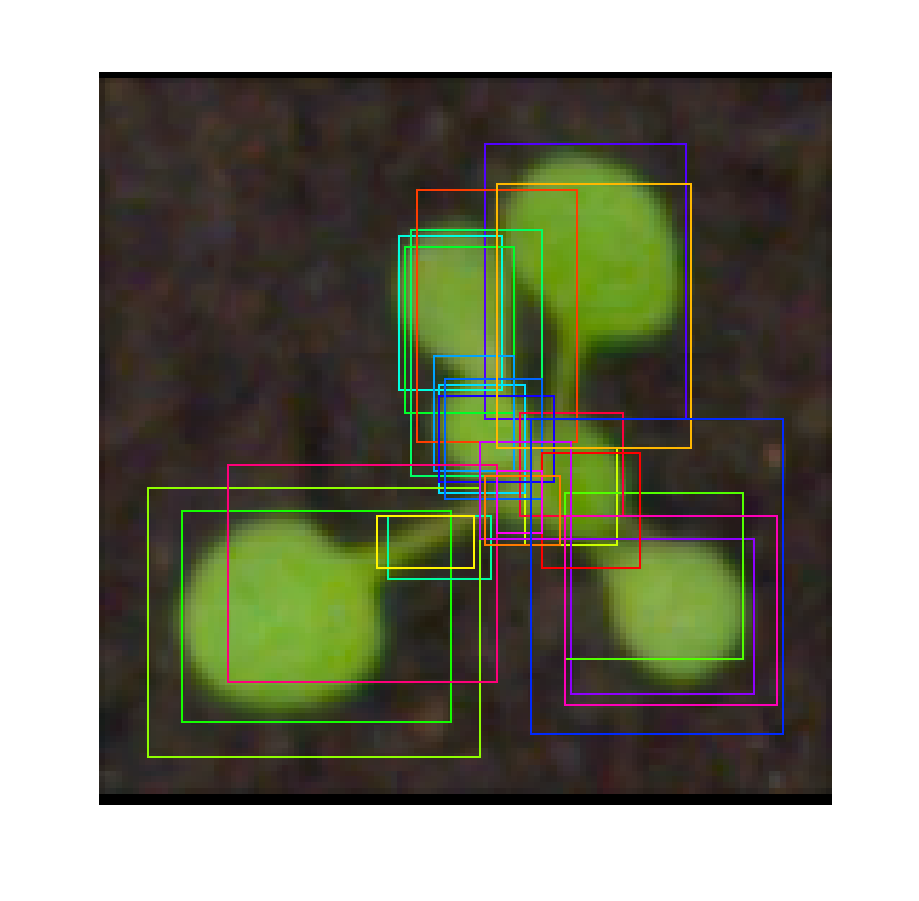

In [44]:
# Show refined anchors after non-max suppression
limit = 25
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

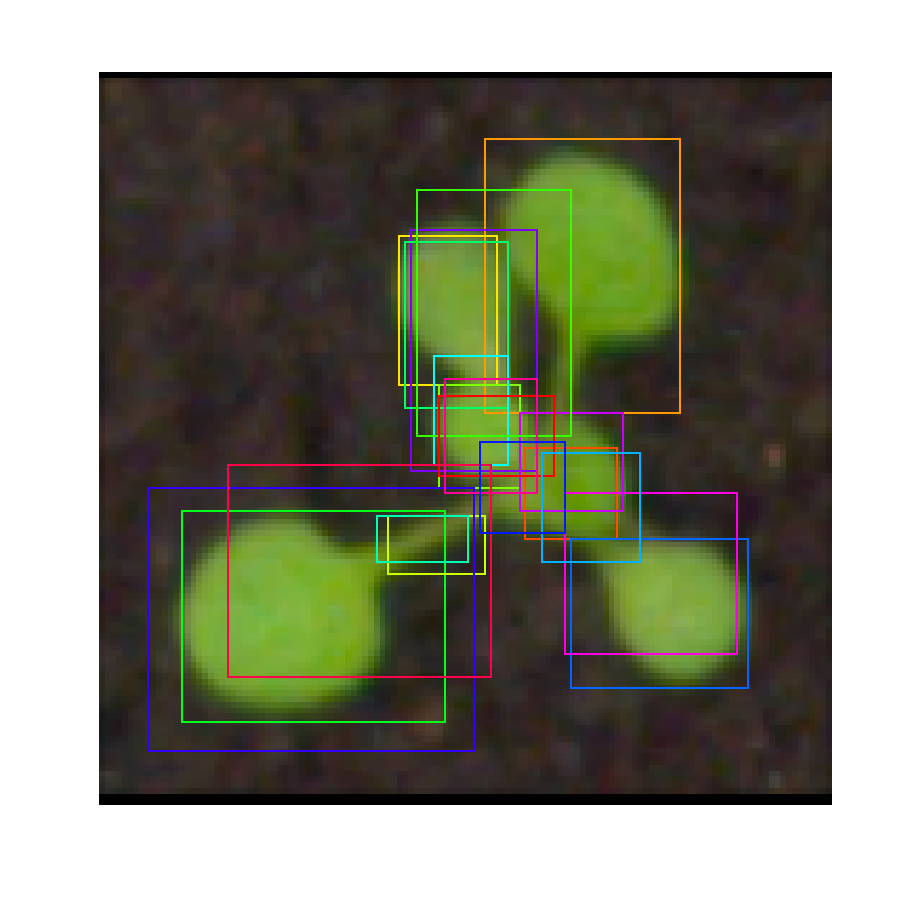

In [45]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 20
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [46]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -4.01209  max:    3.79316  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


6 detections: ['leaf' 'leaf' 'leaf' 'leaf' 'leaf' 'leaf']


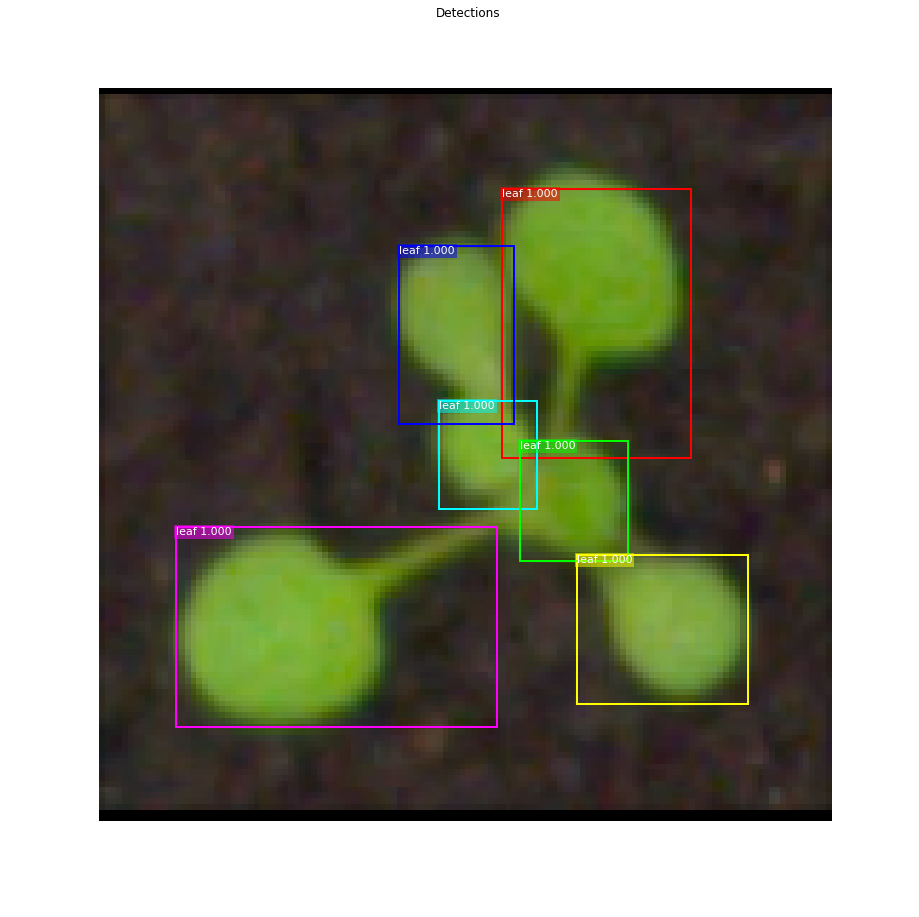

In [47]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [48]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

307 Valid proposals out of 1000
29 Positive ROIs
[('BG', 971), ('leaf', 29)]


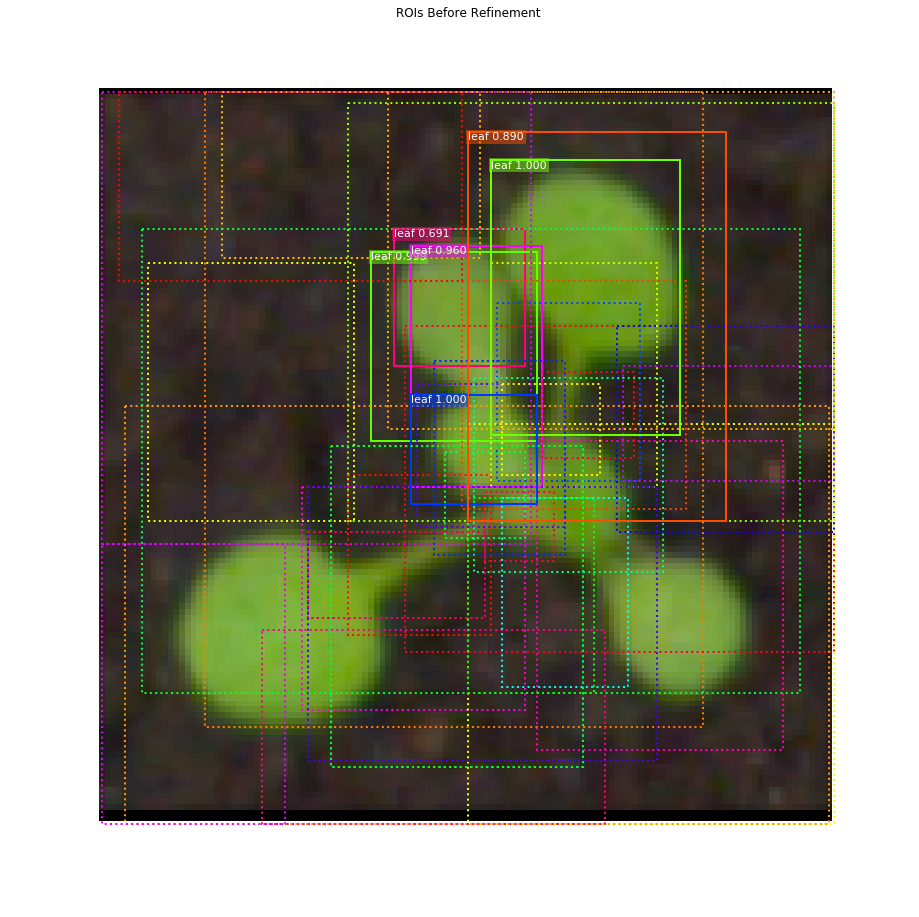

In [51]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 100
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -2.77748  max:    3.11561  float32
refined_proposals        shape: (1000, 4)             min:  -22.00000  max:  171.00000  int32


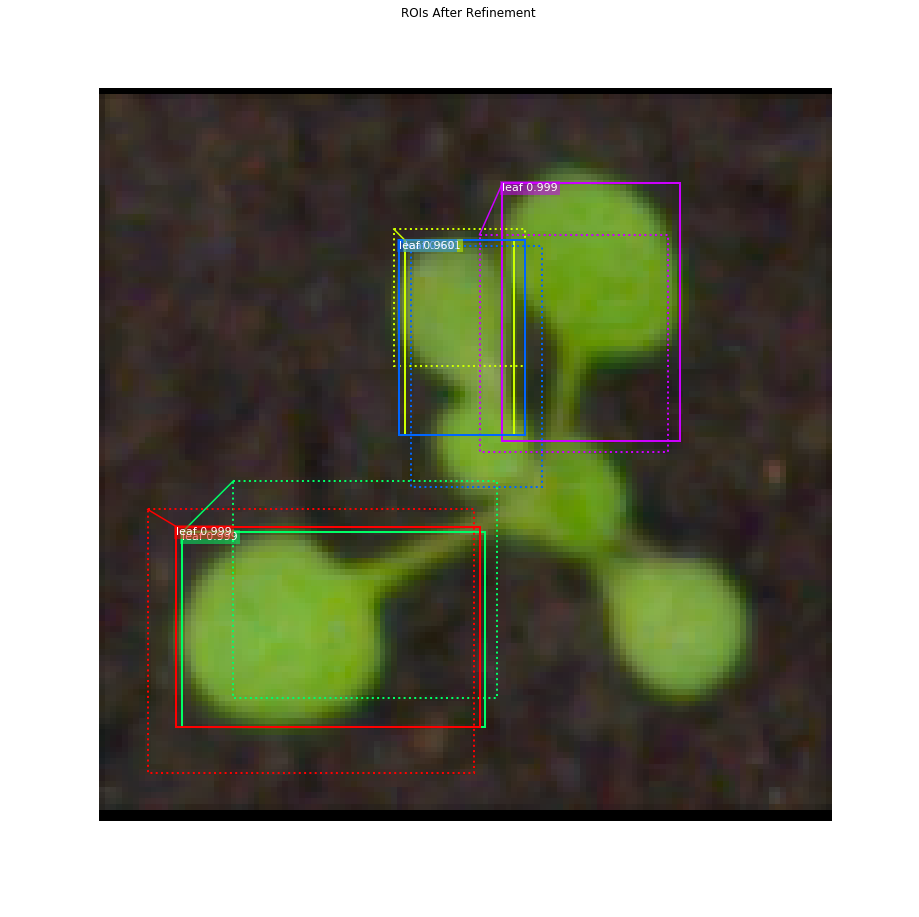

In [52]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [53]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 29 detections:
[  0   1   2   3   4   5   6   7   8   9  10  14  15  16  17  18  22  24
  28  39  40  43  48  65  71 101 104 106 119]


In [54]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 25:
[  0   1   2   3   4   5   6   7   9  10  14  15  16  17  18  22  24  28
  39  40  48  65 104 106 119]


#### Per-Class Non-Max Suppression

In [55]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

leaf                  : [  0   1   2   3   4   5   6   7   9  10  14  15  16  17  18  22  24  28
  39  40  48  65 104 106 119] -> [22  5  2  3  4  1]

Kept after per-class NMS: 6
[ 1  2  3  4  5 22]


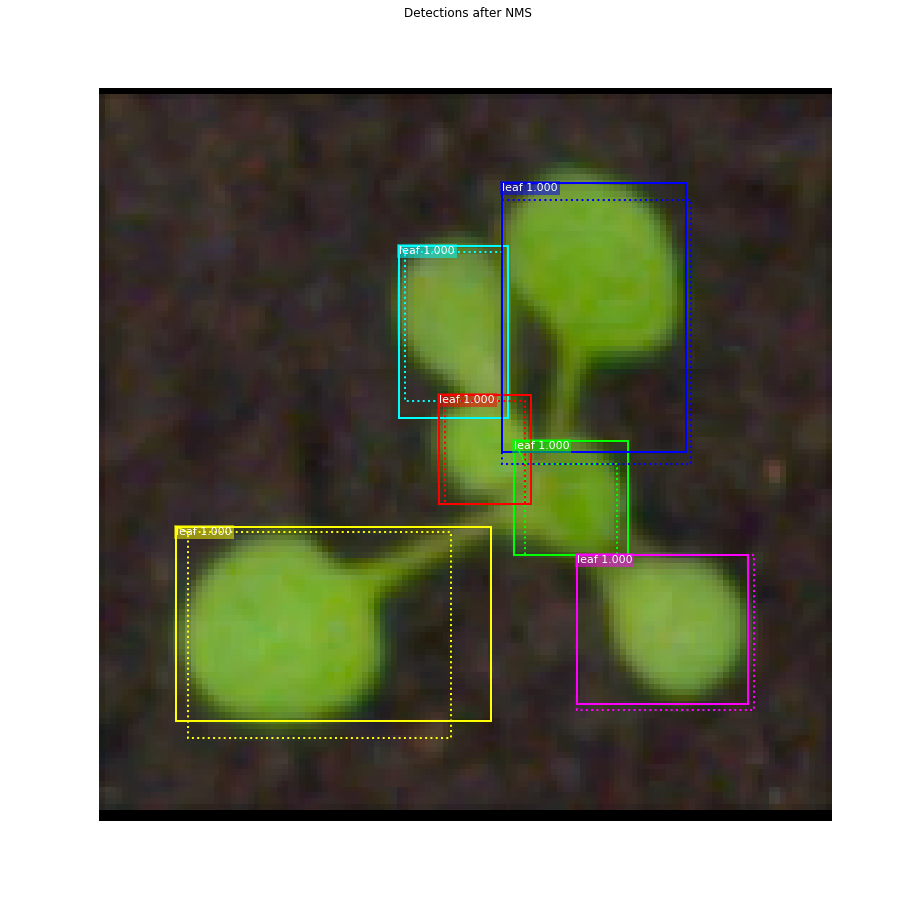

In [56]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

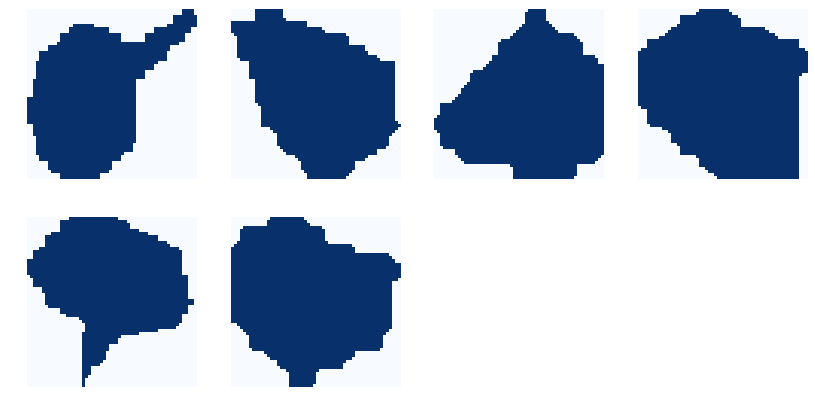

In [57]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [58]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
6 detections: ['leaf' 'leaf' 'leaf' 'leaf' 'leaf' 'leaf']


In [59]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (6, 28, 28)           min:    0.00000  max:    1.00000  float32
det_masks                shape: (6, 128, 128)         min:    0.00000  max:    1.00000  bool


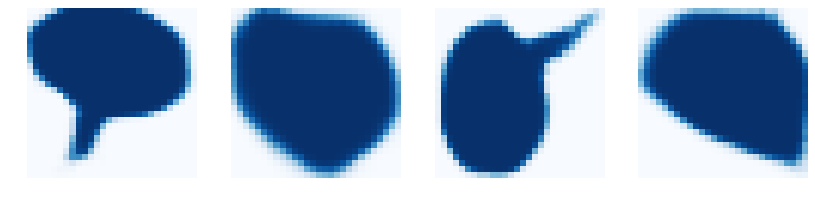

In [60]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

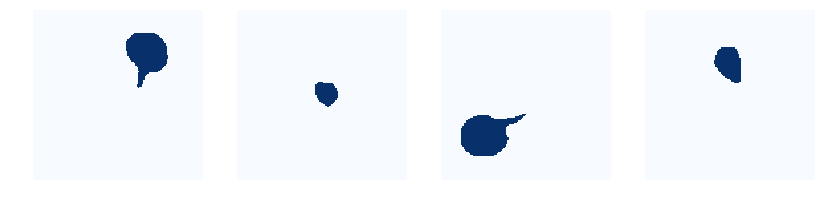

In [61]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [62]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
#     ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 128, 128, 3)      min: -123.70000  max:   68.20000  float32
res2c_out                shape: (1, 32, 32, 256)      min:    0.00000  max:   19.93483  float32
res3c_out                shape: (1, 16, 16, 512)      min:    0.00000  max:   28.34686  float32
rpn_bbox                 shape: (1, 4092, 4)          min:  -15.62716  max:   73.24988  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


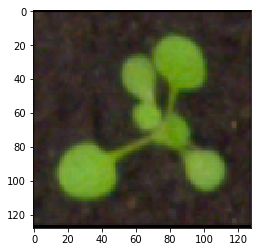

In [64]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

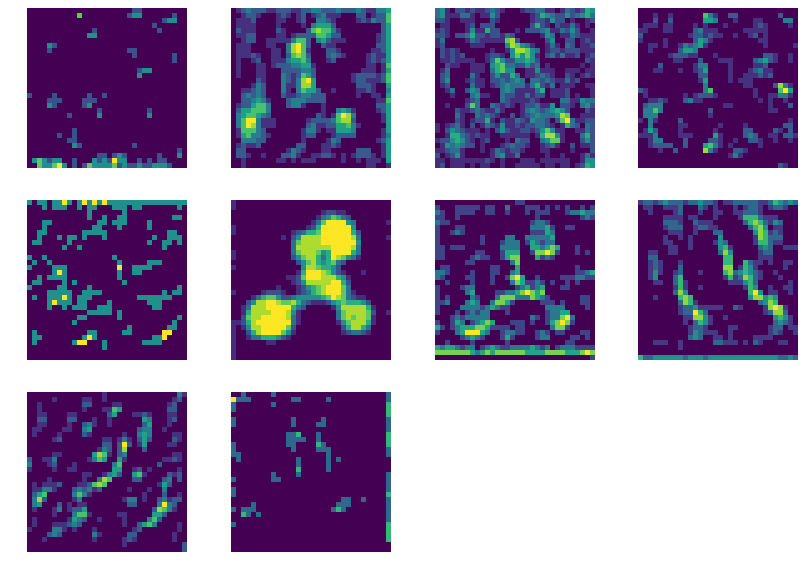

In [66]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:10], [2, 0, 1]), cols=4)